In [1]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)
import os
os.environ['OMP_NUM_THREADS'] = '1'
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
import CyclicMDP
from CyclicMDP import CyclicMDP
import numpy as np
import time
import datetime
!pip3 install box2d-py==2.3.8
!pip install gym==0.15.4 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch import optim
import pickle as pkl

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/'
os.sched_setaffinity(os.getpid(), {0})
os.system("taskset -p 0xffffffff %d" % os.getpid())
from torch.distributions import MultivariateNormal
import gym
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Mounted at /content/drive


In [0]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


In [0]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 32),
                nn.Tanh(),
                nn.Linear(32, 32),
                nn.Tanh(),
                nn.Linear(32, action_dim),
                nn.Tanh()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 32),
                nn.Tanh(),
                nn.Linear(32, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy


In [0]:
class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        
        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs), 1).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())


In [0]:

############## Hyperparameters ##############
env_name = "BipedalWalker-v2"
render = False
solved_reward = 500         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 3000        # max training episodes
max_timesteps = 1000        # max timesteps in one episode

update_timestep = 10      # update policy every n timesteps
action_std = 0.5            # constant std for action distribution (Multivariate Normal)
K_epochs = 100               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr = 0.0001                # parameters for Adam optimizer
betas = (0.9, 0.999)

all_rewards = []
time_list = []
rolling_avg_reward = []
#############################################

# creating environment
# env = gym.make(env_name)
# state_dim = env.observation_space.shape[0]
# # action_dim = env.action_space.n
# action_dim = env.action_space.shape[0]

env = CyclicMDP()
state_dim = 3
action_dim = 3

memory = Memory()
ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)

# training loop
for i_episode in range(1,max_episodes+1):
  running_reward = 0
  time_step = 0
  done = False

  start = time.time()
  state = env.reset()
  while done==False:
    time_step +=1
    # Running policy_old:
    action = ppo.select_action(state, memory)
    action = np.argmax(action)
    state, reward, done, _ = env.step(action)

    # Saving reward and is_terminals:
    memory.rewards.append(reward)
    memory.is_terminals.append(done)
    running_reward += reward

  if i_episode %5 ==0:
    ppo.update(memory)
    memory.clear_memory()
  state = env.reset()

  end = time.time()
  time_list.append(end-start)
  all_rewards.append(running_reward)
  if len(all_rewards)>10:
    rolling_avg_reward.append(np.mean(all_rewards[-10:]))

  # logging and saving
  if i_episode % log_interval == 0:
    print('Episode {} \t Avg Reward: {} '.format(i_episode, rolling_avg_reward[-1]))
    torch.save({'model_state_dict': ppo.policy.state_dict(), 'optimizer_state_dict': ppo.optimizer.state_dict()},
    checkpoint_name+'actor.pth.tar')


data_save = {}
data_save['avg_reward'] = all_rewards
data_save['rolling_rewards'] = rolling_avg_reward
data_save['time'] = time_list
with open(checkpoint_name+'data.pkl', 'wb') as f:
  pkl.dump(data_save, f)




Episode 20 	 Avg Reward: 1.0 
Episode 40 	 Avg Reward: 12.2 
Episode 60 	 Avg Reward: 5.0 
Episode 80 	 Avg Reward: 15.7 
Episode 100 	 Avg Reward: 28.3 
Episode 120 	 Avg Reward: 57.5 
Episode 140 	 Avg Reward: 49.0 
Episode 160 	 Avg Reward: 119.1 
Episode 180 	 Avg Reward: 92.4 
Episode 200 	 Avg Reward: 86.6 
Episode 220 	 Avg Reward: 56.8 
Episode 240 	 Avg Reward: 133.2 
Episode 260 	 Avg Reward: 118.1 
Episode 280 	 Avg Reward: 125.7 
Episode 300 	 Avg Reward: 148.1 
Episode 320 	 Avg Reward: 297.0 
Episode 340 	 Avg Reward: 365.7 
Episode 360 	 Avg Reward: 367.2 
Episode 380 	 Avg Reward: 189.4 
Episode 400 	 Avg Reward: 436.1 
Episode 420 	 Avg Reward: 232.2 
Episode 440 	 Avg Reward: 306.1 
Episode 460 	 Avg Reward: 416.0 
Episode 480 	 Avg Reward: 361.5 
Episode 500 	 Avg Reward: 188.0 
Episode 520 	 Avg Reward: 268.5 
Episode 540 	 Avg Reward: 173.1 
Episode 560 	 Avg Reward: 131.0 
Episode 580 	 Avg Reward: 256.4 
Episode 600 	 Avg Reward: 260.5 
Episode 620 	 Avg Reward: 

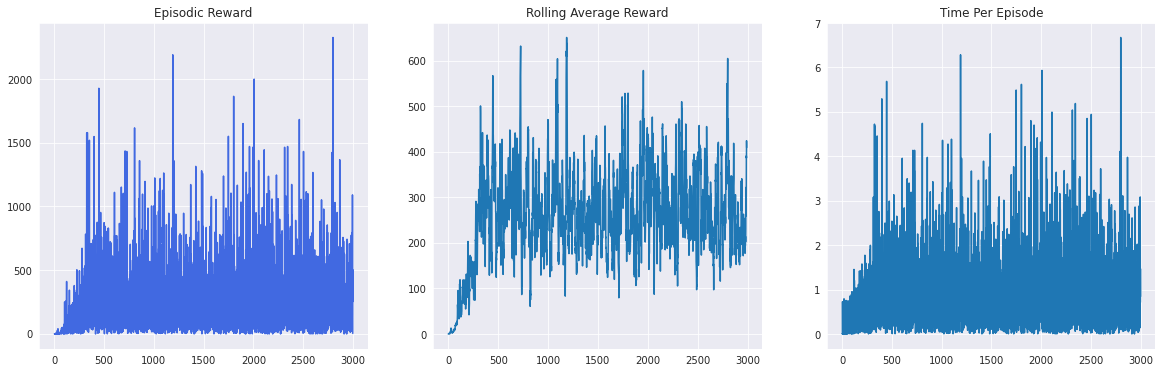

In [0]:
data_save = {}
data_save['avg_reward'] = all_rewards
data_save['rolling_rewards'] = rolling_avg_reward
data_save['time'] = time_list
with open(checkpoint_name+'data.pkl', 'wb') as f:
  pkl.dump(data_save, f)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : True})

plt.figure(figsize=(20,6))


plt.subplot(131)
plt.title('Episodic Reward')
plt.plot(all_rewards, color='royalblue')

plt.subplot(132)
plt.title('Rolling Average Reward')
plt.plot(rolling_avg_reward)

plt.subplot(133)
plt.title('Time Per Episode')
plt.plot(time_list)


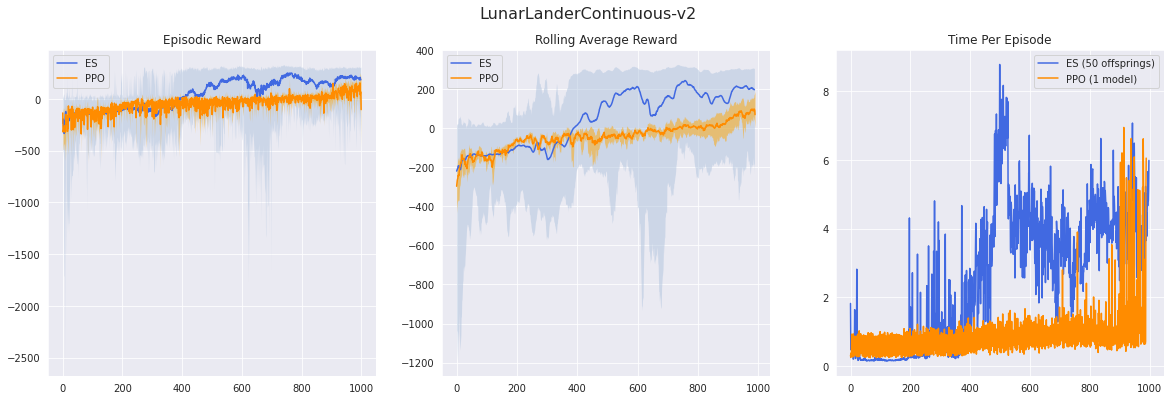

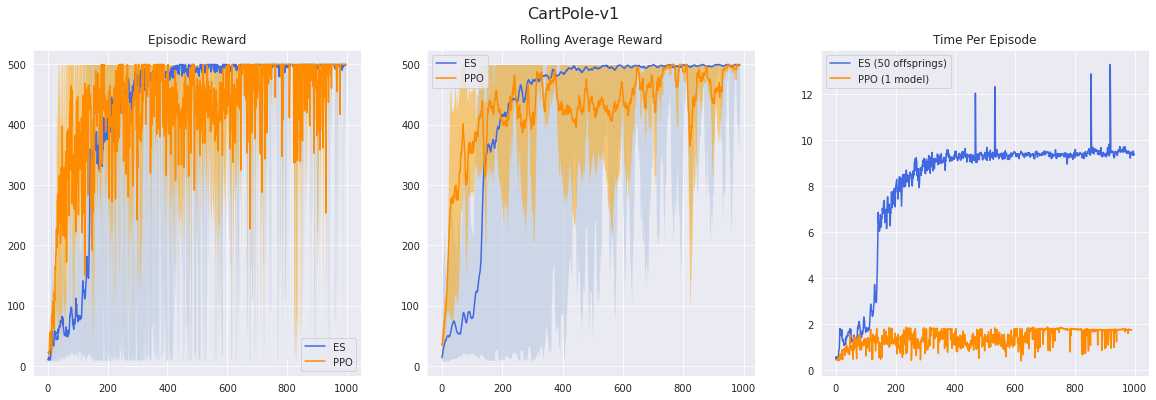

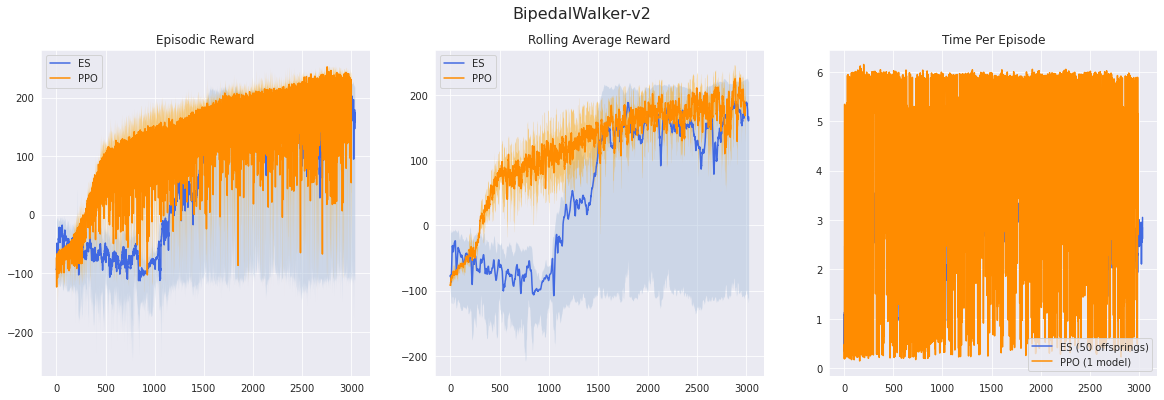

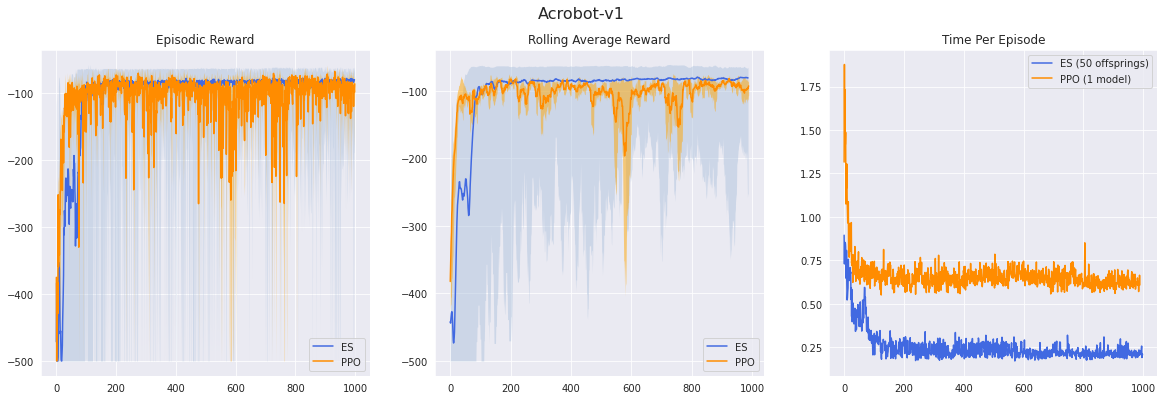

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
es_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/ES/'
ppo_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/PPO/'

env_list = ['LunarLanderContinuous-v2','CartPole-v1','BipedalWalker-v2','Acrobot-v1']

sns.set_style('dark', {'axes.grid' : True})
alpha = 0.5

for env_name in env_list:
  data_ppo_1 = pkl.load(open(ppo_name+env_name+'/v1'+'/data.pkl','rb'))
  data_ppo_2 = pkl.load(open(ppo_name+env_name+'/v2'+'/data.pkl','rb'))
  data_ppo_3 = pkl.load(open(ppo_name+env_name+'/v3'+'/data.pkl','rb'))
  data_es = pkl.load(open(es_name+env_name+'/data.pkl','rb'))
  if env_name=='BipedalWalker-v2':
    x = -1
    subt = 0
  else:
    x = -1
    subt = 1000
  avg_rewards = data_es['avg_reward'][:x]
  max_rewards = data_es['max_rewards'][:x]
  min_rewards = data_es['min_reward'][:x]
  avg_rolling_rewards = data_es['rolling_rewards'][:x]
  max_rolling_rewards = []; min_rolling_rewards = []
  for k in range(11,len(avg_rewards)):
    max_rolling_rewards.append(np.mean(max_rewards[k-10:k]))
    min_rolling_rewards.append(np.mean(min_rewards[k-10:k]))
  
  time_list = data_es['time'][:x]
  avg_rewards_ppo = []; max_rewards_ppo = []; min_rewards_ppo = []
  avg_rolling_rewards_ppo = []; max_rolling_rewards_ppo = []; min_rolling_rewards_ppo = []
  time_list_ppo = []
  i = 0; j = 0

  for i in range(0,len(data_ppo_2['avg_reward'])-subt):
    avg_rewards_ppo.append(np.mean([data_ppo_1['avg_reward'][i],data_ppo_2['avg_reward'][i],data_ppo_3['avg_reward'][i]]))
    max_rewards_ppo.append(max([data_ppo_1['avg_reward'][i],data_ppo_2['avg_reward'][i],data_ppo_3['avg_reward'][i]]))
    min_rewards_ppo.append(min([data_ppo_1['avg_reward'][i],data_ppo_2['avg_reward'][i],data_ppo_3['avg_reward'][i]]))
  for j in range(0,len(data_ppo_2['rolling_rewards'])-subt):
    avg_rolling_rewards_ppo.append(np.mean([data_ppo_1['rolling_rewards'][j],data_ppo_2['rolling_rewards'][j],data_ppo_3['rolling_rewards'][j]]))
    max_rolling_rewards_ppo.append(max([data_ppo_1['rolling_rewards'][j],data_ppo_2['rolling_rewards'][j],data_ppo_3['rolling_rewards'][j]]))
    min_rolling_rewards_ppo.append(min([data_ppo_1['rolling_rewards'][j],data_ppo_2['rolling_rewards'][j],data_ppo_3['rolling_rewards'][j]]))
    time_list_ppo.append(min([data_ppo_1['time'][j],data_ppo_2['time'][j],data_ppo_3['time'][j]]))


  plt.figure(figsize=(20,6))
  plt.suptitle(env_name,fontsize='16')

  plt.subplot(131)
  plt.title('Episodic Reward')
  plt.plot(np.arange(0,len(avg_rewards),1),avg_rewards, color='royalblue')
  plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue', alpha=alpha, linewidth=0, antialiased=True)
  plt.plot(np.arange(0,len(avg_rewards_ppo),1),avg_rewards_ppo, color='darkorange')
  plt.fill_between(np.arange(0,len(avg_rewards_ppo),1),min_rewards_ppo,max_rewards_ppo,facecolor='orange',alpha=alpha, linewidth=0, antialiased=True)
  plt.legend(['ES','PPO'])

  plt.subplot(132)
  plt.title('Rolling Average Reward')
  plt.plot(avg_rolling_rewards, color='royalblue')
  plt.fill_between(np.arange(0,len(avg_rolling_rewards),1),min_rolling_rewards,max_rolling_rewards,facecolor='lightsteelblue',alpha=alpha, linewidth=0, antialiased=True)
  plt.plot(np.arange(0,len(avg_rolling_rewards_ppo),1),avg_rolling_rewards_ppo, color='darkorange')
  plt.fill_between(np.arange(0,len(avg_rolling_rewards_ppo),1),min_rolling_rewards_ppo,max_rolling_rewards_ppo,facecolor='orange',alpha=alpha, linewidth=0, antialiased=True)
  plt.legend(['ES','PPO'])

  plt.subplot(133)
  plt.title('Time Per Episode')
  plt.plot(time_list,color='royalblue')
  plt.plot(time_list_ppo,color='darkorange')
  plt.legend(['ES (50 offsprings)','PPO (1 model)'])




In [13]:
print(len(data_ppo_3['avg_reward']))

2000


In [5]:
print(i)

2000
